# Modelling

### Questions Considered Before Modeling

As modeling begins, it would generally be helpful to have clarity on the following points, as they could influence key decisions in a real-world setting:

1. How will predictions be used? Understanding whether predictions support human review or trigger automated actions would affect how cautious the model should be.
2. What is more costly: false positives or false negatives?  
This would help determine how conservative the model should be, especially when selecting thresholds or optimizing for specific types of errors.
3. Will the model be used in real-time or batch processing?  
Clarifying this helps assess whether model performance (e.g., speed, memory footprint) needs to be a priority.

###  General approach

Given the limited context - aside from the note that this dataset is based on a real bot incident and contains at least one bot (≥1% of requests) - modeling will begin with the **Isolation Forest** algorithm, a commonly used approach for unsupervised anomaly detection.

The model will be saved as part of a complete end-to-end pipeline, as reqested in the assignment requirements.

After training, the results will be reviewed to understand what types of requests the algorithm is flagging, the potential reasoning behind those anomalies, and which features appear to contribute most to the outlier scores.

Since the input dataset was originally split into three parts _(note: during feature engineering, the first two datasets were consolidated as fine-tuning won't be performed)_, the trained model will be evaluated on the holdout set. This will help assess the model’s stability and generalization to unseen data.


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import pickle

# modelling
from sklearn.ensemble import IsolationForest

# cleaning
from urllib.parse import unquote

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# evaluation
from kneed import KneeLocator
import shap

# add parent directory to path for absolute imports
sys.path.append(os.path.abspath('..'))
from transform import FeatureTransformation

In [2]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Read and transform raw data

In [3]:
# load data
df_train_raw = pd.read_csv("../data/train.csv", sep="\t")
df_test_raw = pd.read_csv("../data/test.csv", sep="\t")

# combining after all as there won't be any fine tuning on the test set
df_all_raw = pd.concat([df_train_raw, df_test_raw], axis=0, ignore_index=True)

# transform data
feature_transformation = FeatureTransformation(
    fasttext_model_path="../models/cc.en.300.bin",
    svd_model_path="../models/svd_model.pkl",
)
df_train = feature_transformation.transform(df_all_raw)

2025-07-15 23:33:01,615 - transform - INFO - FeatureTransformation initialized
2025-07-15 23:33:01,616 - transform - INFO - Starting transformation pipeline with 14064 rows and 5 columns
2025-07-15 23:33:07,223 - transform - INFO - After cleaning: 14064 rows and 25 columns
2025-07-15 23:33:07,299 - transform - INFO - After categorical encoding: 14064 rows and 32 columns
2025-07-15 23:33:07,316 - transform - INFO - After dropping constant columns: 14064 rows and 25 columns
2025-07-15 23:33:07,393 - transform - INFO - After sparse encoding: 14064 rows and 33 columns
2025-07-15 23:33:07,481 - transform - WARNING - Adding 5 missing columns
2025-07-15 23:33:07,486 - transform - WARNING - New values in columns: ['bkl_r1-36', 'bkl_wikipedia_portuguese', 'bkl_wikipedia_french_deep', 'bkl_news', 'bkl_r1-49']
2025-07-15 23:33:07,536 - transform - INFO - After SVD sparse combination: 14064 rows and 33 columns
2025-07-15 23:33:07,628 - transform - WARNING - Found 3 invalid country codes, replacing

In [4]:
param_df = df_all_raw['params_dict'].apply(pd.Series)
df_manual = pd.concat([
    df_all_raw.drop(columns=['url_params','params_dict']),
    param_df],
    axis=1
)
df_manual['q'] = df_manual['q'].apply(unquote)

In [5]:
# Check data types
print("Data types:")
print(df_train.dtypes.value_counts())

# Check for any non-numeric data
non_numeric = df_train.select_dtypes(exclude=['number'])
print(f"\nNon-numeric columns: {list(non_numeric.columns)}")

Data types:
float32    600
int64       29
float64     14
int32        1
Name: count, dtype: int64

Non-numeric columns: []


### Train Isolation Forest Model

The Isolation Forest algorithm requires a `contamination` parameter to define the expected proportion of outliers. While setting it to `0.01` would align with the hint that at least 1% of traffic is bot-related, this would force the model to flag exactly 1% of data as anomalies - based purely on the lowest anomaly scores.

Instead, `contamination='auto'` is used to let the model infer the threshold from the data itself, allowing for a more natural separation if one exists.

In [6]:
iso_forest = IsolationForest(
    contamination='auto',  # Expected proportion of anomalies
    random_state=42,
    n_estimators=100,
    max_samples='auto'
)

# Fit and predict
anomaly_scores_train = iso_forest.fit_predict(df_train) # predicts -1 for anomalies
anomaly_scores_decision_train = iso_forest.decision_function(df_train)

#### Analyze results

In [7]:
# Create results DataFrame
res_df_train = df_train.copy()
res_df_train = pd.concat([res_df_train, df_all_raw[['datetime']]], axis=1) # add back original timestamp

res_df_train['anomaly_score'] = anomaly_scores_decision_train
res_df_train['is_anomaly'] = (anomaly_scores_train == -1)

In [8]:
# Score distribution
print("\nAnomaly score statistics:")
print(f"Mean: {res_df_train['anomaly_score'].mean():.4f}")
print(f"Std: {res_df_train['anomaly_score'].std():.4f}")
print(f"Min: {res_df_train['anomaly_score'].min():.4f}")
print(f"Max: {res_df_train['anomaly_score'].max():.4f}")

n_total_train = len(res_df_train)
n_anom = res_df_train["is_anomaly"].sum()
anomaly_percentage = (n_anom / n_total_train) * 100
print(f"\nAnomalies:")
print(f"Total samples: {n_total_train}")
print(f"Anomalies detected: {n_anom}")
print(f"Anomaly percentage: {anomaly_percentage:.2f}%")


Anomaly score statistics:
Mean: 0.1230
Std: 0.0449
Min: -0.1887
Max: 0.1720

Anomalies:
Total samples: 14064
Anomalies detected: 416
Anomaly percentage: 2.96%


_Note_:  The detected anomaly rate is 2.96%, which is notably higher than the hinted minimum of 1%. However, without access to ground-truth labels, it's difficult to determine whether this rate is appropriate or meaningful.

##### Elbow method on splitting the data

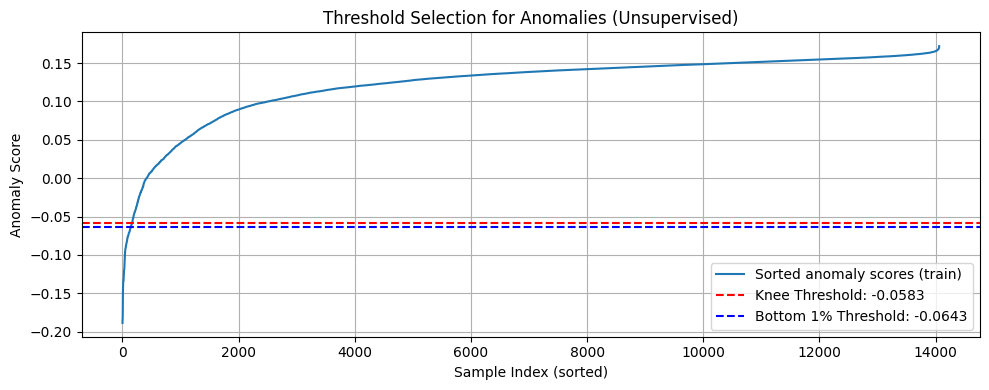

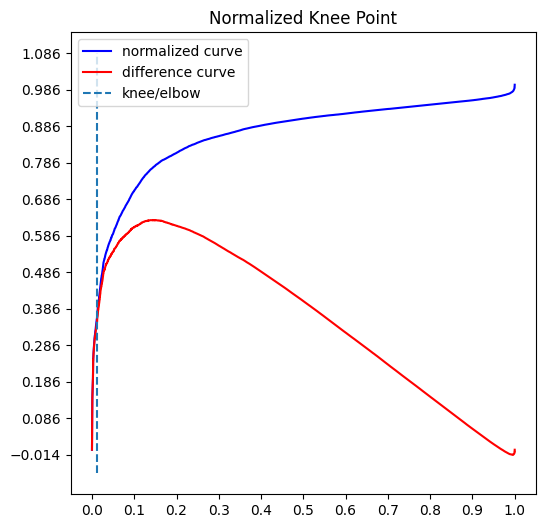

In [9]:
# Sort scores (lower = more anomalous)
sorted_scores = np.sort(anomaly_scores_decision_train)

# Find knee point (where curvature changes most)
knee = KneeLocator(
    x=range(len(sorted_scores)),
    y=sorted_scores,
    curve='concave',
    direction='increasing',
    online=False
)
knee_threshold = sorted_scores[knee.knee]
# calculating also bottom 1% threshold
bottom_threshold = np.percentile(anomaly_scores_decision_train, 1)

plt.figure(figsize=(10, 4))
plt.plot(sorted_scores, label='Sorted anomaly scores (train)')
plt.axhline(
    knee_threshold,
    color='red',
    linestyle='--',
    label=f'Knee Threshold: {knee_threshold:.4f}'
)
plt.axhline(
    bottom_threshold,
    color='blue',
    linestyle='--',
    label=f'Bottom 1% Threshold: {bottom_threshold:.4f}'
)

plt.title('Threshold Selection for Anomalies (Unsupervised)')
plt.xlabel('Sample Index (sorted)')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

knee.plot_knee_normalized()

In [11]:
knee_anomalies_count = sum(anomaly_scores_decision_train < knee_threshold)
print(
    "Using knee threshold as the cutoff value for anomalies, "
    f"{knee_anomalies_count} anomalies were identified, which represents "
    f"{knee_anomalies_count / len(anomaly_scores_decision_train) * 100:.2f}% "
    "of the training data."
)

Using knee threshold as the cutoff value for anomalies, 166 anomalies were identified, which represents 1.18% of the training data.


Using the elbow method’s suggested cutoff would reduce the anomaly rate from 2.96% to 1.18%. However, this adjustment would rely solely on the assingment's hint. These anomalies can still be reviewed manually, under the assumption that there are strong signals indicating they are genuine anomalies.

In [12]:
manually_check = res_df_train[res_df_train['anomaly_score'] < knee_threshold].index

# printing last rows for the notebook
df_manual.loc[manually_check].tail()

,datetime,region,browser,device,hour,n,f,d,sld,st,nt,r,adx,adx_name,ttc,q,ct,kl,kp,bkl,lsexp1,om,atb,atbva,va,atbexp
13737,2019-12-02 18:40:50,Mars,Chrome,Android,18,1,1,www8.hp.com,0,mobile_search_intl,0,0,none,none,14101,heder teca disgregate boatel,ZA,wt-wt,-2,r1-15,NaN,NaN,NaN,NaN,NaN,NaN
13762,2019-12-02 18:45:07,Mars,Chrome,Android,18,1,1,fnac.es,1,mobile_search_intl,0,0,none,none,7125,pows,ES,es-es,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13881,2019-12-02 18:58:21,Earth,Safari,Android,18,1,1,www.viagogo.com,1,mobile_search_intl,0,null,def,none,3668,benn,DE,wt-wt,-1,r1-1,NaN,NaN,NaN,NaN,NaN,NaN
13913,2019-12-02 19:02:35,Earth,Chrome,Android,19,1,1,www.Shape.com,0,mobile_search_intl,0,0,none,none,1591,z1,HK,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14000,2019-12-02 19:11:50,Mars,Chrome,Android,19,1,1,www.size.co.uk,0,mobile_search_intl,0,0,none,none,6859,chok,GB,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at the anomalous observations, several patterns emerge related to query length, query content, and domain length. Time-to-click could also be influential, as it is generally smaller compared to the overall dataset.

Exceptions: there are two observations with even shorter queries - only a single character. However, these one-character queries fall into the `normal_fast` time-to-click bin and are associated with longer ad domains (in terms of character count).

##### Anomaly explanation: LIME

The LIME method is used to explain why certain cases are seen as anomalous by building a simple local model around the anomaly score and showing which features mattered most.

In [16]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=df_train.values,
    feature_names=df_train.columns.tolist(),
    mode='regression',
    verbose=True
)

In [17]:
# let's look at most anomalous case
idx = res_df_train\
    .loc[res_df_train['anomaly_score'] < knee_threshold, 'anomaly_score']\
    .idxmin()
instance = df_train.iloc[idx].values.reshape(1, -1)
explanation = explainer.explain_instance(
    instance.flatten(),
    # preserve column names
    # also (-) to flip score; higher = more anomalous
    predict_fn=lambda x: -iso_forest.decision_function(pd.DataFrame(x, columns=df_train.columns)).reshape(-1, 1),
    num_features=50
)


Intercept -0.07240963948251539
Prediction_local [-0.02182352]
Right: 0.18866870976434236


In [18]:
print(f"Explained variance by the model: {explanation.score:.4f}")

Explained variance by the model: 0.1992


The local surrogate model predicted an anomaly score of -0.022 (with an intercept of -0.072), while the actual model output was 0.189. The explained variance is only 19.9%, indicating that LIME provides a weak local approximation in this case.

However, the feature rules generated by the LIME model can still offer useful insights into factors contributing to normal or anomalous observations

In [20]:
# Get explanation as list of (feature_rule, weight) tuples
exp_list = explanation.as_list()
# Sort by weight
sorted_exp = sorted(exp_list, key=lambda x: x[1])

most_anomalous = sorted_exp[:5]
most_normal = sorted_exp[-3:]

# Print results
print("🔺 Most Anomalous Features:")
for rule, weight in most_anomalous:
    print(f"{rule}: {weight:.4f}")

print("\n🔹 Most Normal Features:")
for rule, weight in reversed(most_normal):  # descending
    print(f"{rule}: {weight:.4f}")


🔺 Most Anomalous Features:
r_2 <= 0.00: -0.0070
region_Venus <= 0.00: -0.0049
r_1 <= 0.00: -0.0047
kp_-2 <= 0.00: -0.0036
region_Mercury <= 0.00: -0.0028

🔹 Most Normal Features:
q_ft_dim_119 <= -0.01: 0.0034
domain_ft_dim_256 > 0.01: 0.0032
domain_ft_dim_18 <= -0.01: 0.0029


From the LIME rules, it seems that the most anomalous features are largely categorical and structural, such as absence from regions like Venus and Mercury, along with low values of `r_1`, `r_2`, and `kp_-2`. These factors collectively increase the likelihood of an observation being flagged as anomalous.

The features contributing to more ‘normal’ behavior appear to come from domain and query embedding dimensions (e.g., `q_ft_dim_119`, `domain_ft_dim_256`, and `domain_ft_dim_18`). However, the general assumption remains that these embeddings are the most influential factors determining whether a sample is classified as anomalous or not.

In [ ]:
#with open("03-1_lime_explanation.html", "w") as f:
#    f.write(explanation.as_html())

##### Feature importance: SHAP

Although SHAP is not ideally suited for unsupervised models like `IsolationForest`, it is used here to approximate feature importance. `IsolationForest` does not natively provide feature importances, making SHAP a practical - albeit imperfect - workaround. SHAP values do not directly reflect the tree-based isolation mechanism used by the model, however can give some insight, similar to above approach.


In [22]:
explainer = shap.Explainer(iso_forest, df_train)
shap_values = explainer(df_train)

100%|===================| 14032/14064 [01:43<00:00]        

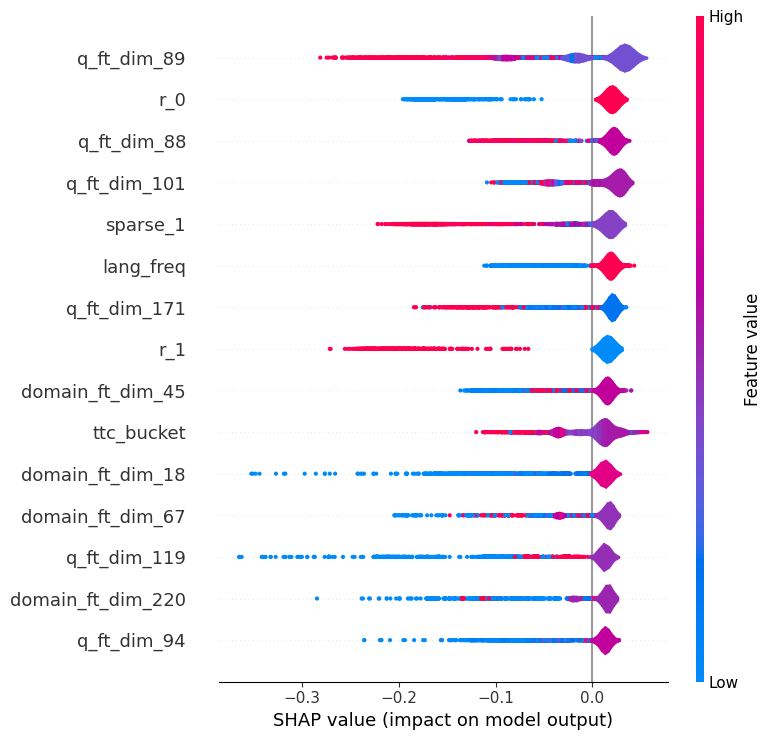

In [23]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top_all_idx = np.argsort(mean_abs_shap)
top_n_idx = 15

top_features = df_train.columns[top_all_idx[-top_n_idx:]]

# Subset shap_values for top features only
shap.summary_plot(
    shap_values[:, top_all_idx[-top_n_idx:]],
    df_train.iloc[:, top_all_idx[-top_n_idx:]],
    plot_type='violin'
)


SHAP again highlights query and domain embeddings (`q_ft_dim_*`, `domain_ft_dim_*`) as strong contributors to anomaly scores, despite their abstract nature.

Features like ttc_bucket show that lower values (corresponding to very fast and fast clicks) contribute more strongly to anomaly classification, which makes sense in this context.

##### UMAP
UMAP is a great dimensionality reduction technique used to project high-dimensional data into two dimensions for visualization. It processes the entire feature vector of each observation and maps it into a 2D space, preserving the structure and relationships from the original data as much as possible.

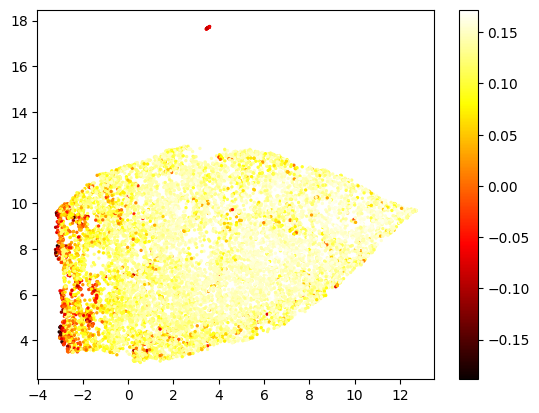

In [24]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(df_train)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=res_df_train['anomaly_score'],
    cmap='hot',
    s=2
)
plt.colorbar()
plt.show()

The UMAP visualization shows that most click traffic forms a dense, central cluster, representing normal behavior. Outliers appear along the edges and in a distinct, isolated region at the top — these represent anomalous behavior based on their separation from the main distribution and low anomaly scores.

Next, out of curiosity, let's visualize only the query, domain, variable `r`, and time-to-click features.

In [29]:
check_cols = [
    x for x in df_train.columns
    if (
        x.startswith('q_')
        or x.startswith('domain_')
        or x.startswith('extension_')
        or x == 'ttc_log'
        or x == 'ttc_bucket'
    )
]


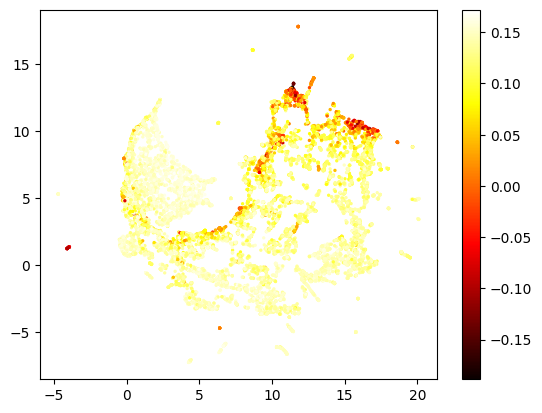

In [34]:
reducer_test = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2)
embedding_test = reducer_test.fit_transform(df_train[check_cols])

plt.scatter(
    embedding_test[:, 0],
    embedding_test[:, 1],
    c=res_df_train['anomaly_score'],
    cmap='hot',
    s=2
)
plt.colorbar()
plt.show()

The UMAP projection forms a wave-like structure, with anomalies (darker points) concentrated along the outer edges and in a few isolated spots.

##### Plot anomaly score distributions


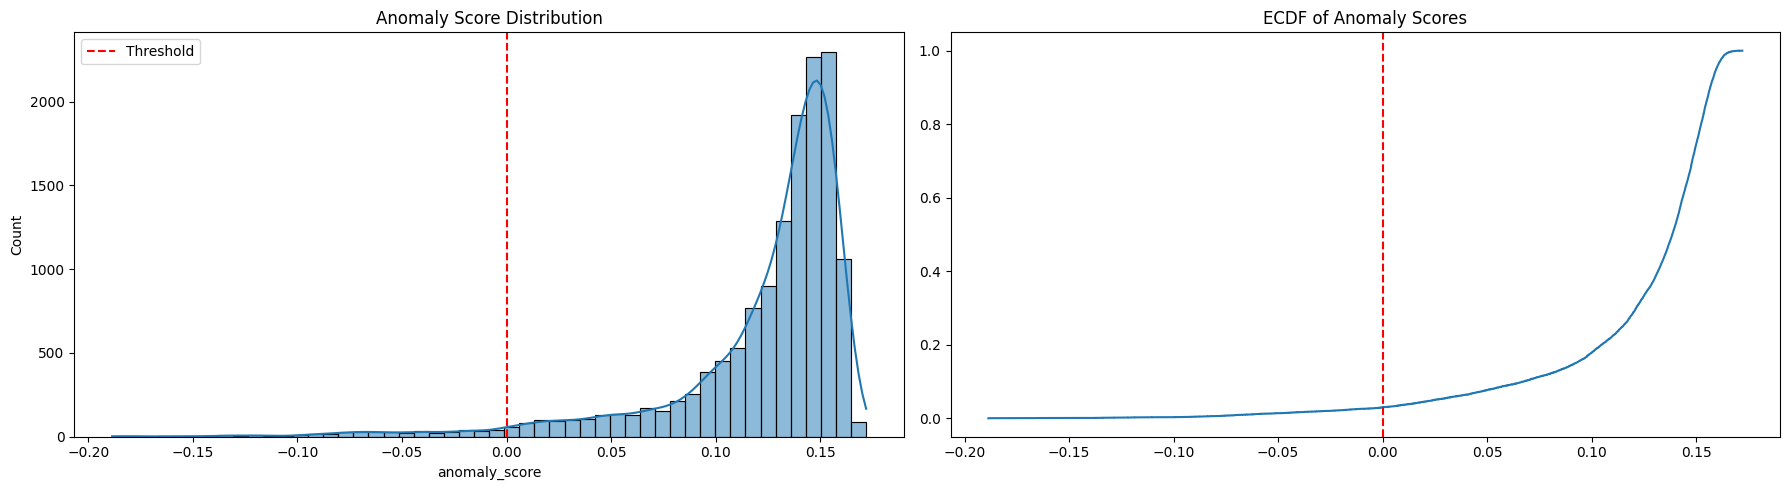

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

def plot_score_distribution(df, threshold):
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # Histogram
    sns.histplot(df['anomaly_score'], bins=50, kde=True, ax=axes[0])
    axes[0].axvline(threshold, color='red', linestyle='--', label='Threshold')
    axes[0].set_title("Anomaly Score Distribution")
    axes[0].legend()

    # ECDF
    ecdf = ECDF(df['anomaly_score'])
    axes[1].step(ecdf.x, ecdf.y)
    axes[1].axvline(threshold, color='red', linestyle='--')
    axes[1].set_title("ECDF of Anomaly Scores")

    plt.tight_layout()
    plt.show()

plot_score_distribution(res_df_train, 0)

#### Temporal Behavior of Anomalies

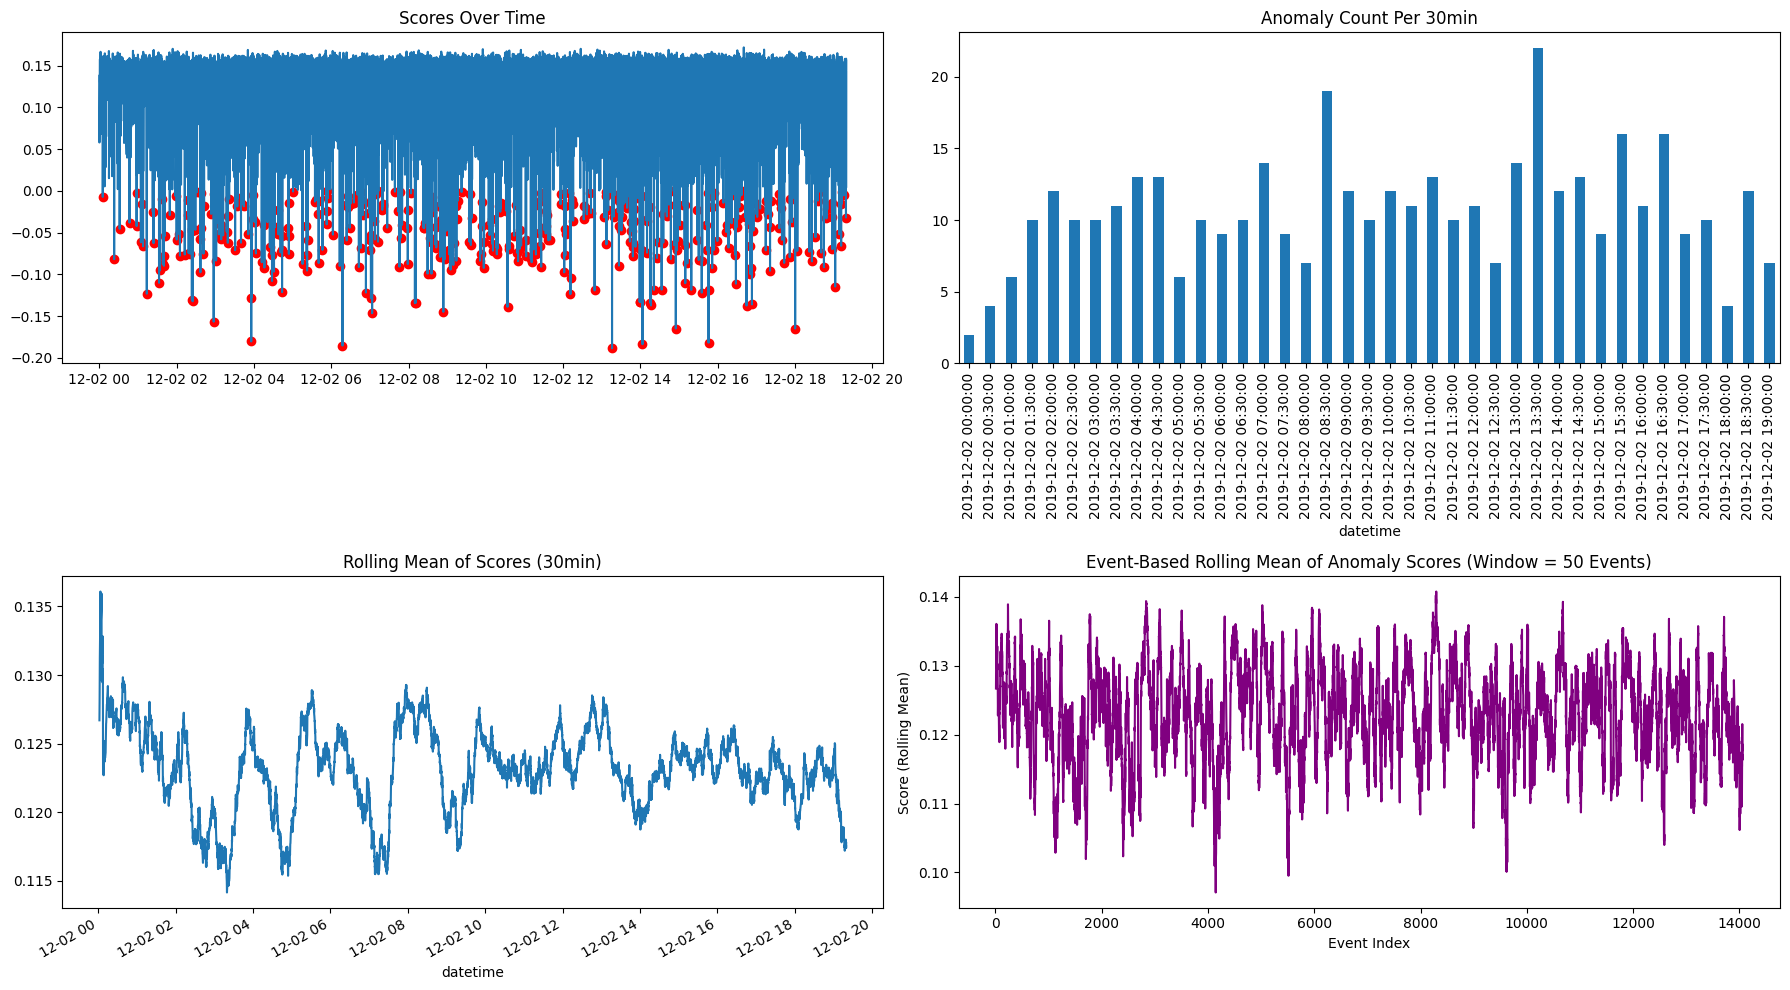

In [37]:
def plot_temporal_patterns(df):
    # Ensure datetime is properly formatted
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'], format='%H:%M:%S')
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # Anomaly scores over time
    axes[0,0].plot(df['datetime'], df['anomaly_score'])
    axes[0,0].scatter(df[df['is_anomaly']]['datetime'], df[df['is_anomaly']]['anomaly_score'], color='red')
    axes[0,0].set_title("Scores Over Time")

    # Anomaly count per 30min
    anomaly_bins = df.set_index('datetime').resample('30min')['is_anomaly'].sum()
    anomaly_bins.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title("Anomaly Count Per 30min")

    # Rolling mean (time-based)
    df_roll = df.set_index('datetime').sort_index()
    roll_mean = df_roll['anomaly_score'].rolling('30min', min_periods=10).mean()
    roll_mean.plot(ax=axes[1, 0])
    axes[1,0].set_title("Rolling Mean of Scores (30min)")

    # Rolling mean (event-based)
    df_sorted = df.sort_values('datetime').reset_index(drop=True)
    df_sorted['rolling_score_event_based'] = df_sorted['anomaly_score']\
        .rolling(window=50, min_periods=10).mean()
    axes[1, 1].plot(df_sorted.index, df_sorted['rolling_score_event_based'], color='purple')
    axes[1, 1].set_title("Event-Based Rolling Mean of Anomaly Scores (Window = 50 Events)")
    axes[1, 1].set_xlabel("Event Index")
    axes[1, 1].set_ylabel("Score (Rolling Mean)")

    plt.tight_layout()
    plt.show()

plot_temporal_patterns(res_df_train)

## Evaluate model's stability on holdout set

In [38]:
# get and transform raw data into features
df_holdout_raw = pd.read_csv("../data/holdout.csv", sep="\t")
df_hold = feature_transformation.transform(df_holdout_raw)

2025-07-15 23:55:34,635 - transform - INFO - Starting transformation pipeline with 1563 rows and 5 columns
2025-07-15 23:55:35,283 - transform - INFO - After cleaning: 1563 rows and 25 columns
2025-07-15 23:55:35,299 - transform - INFO - After categorical encoding: 1563 rows and 32 columns
2025-07-15 23:55:35,304 - transform - INFO - After dropping constant columns: 1563 rows and 25 columns
2025-07-15 23:55:35,338 - transform - INFO - After sparse encoding: 1563 rows and 33 columns
2025-07-15 23:55:35,374 - transform - WARNING - Adding 32 missing columns
2025-07-15 23:55:35,406 - transform - WARNING - New values in columns: ['bkl_r1-23', 'bkl_r1-19', 'bkl_r1-35', 'bkl_recipes', 'bkl_news']
2025-07-15 23:55:35,437 - transform - INFO - After SVD sparse combination: 1563 rows and 33 columns
2025-07-15 23:55:39,306 - transform - INFO - After domain feature extraction: 1563 rows and 341 columns
2025-07-15 23:55:40,391 - transform - INFO - After query processing: 1563 rows and 644 columns
20

In [39]:
# get and save anomaly scores for holdout set
anomaly_scores_hold = iso_forest.predict(df_hold)
anomaly_scores_decision_hold = iso_forest.decision_function(df_hold)

res_df_hold = df_hold.copy()
res_df_hold['anomaly_score'] = anomaly_scores_decision_hold
res_df_hold['is_anomaly'] = (anomaly_scores_hold == -1)

In [40]:
# Score distribution
print("\nAnomaly score statistics:")
print(f"Mean: {res_df_hold['anomaly_score'].mean():.4f}")
print(f"Std: {res_df_hold['anomaly_score'].std():.4f}")
print(f"Min: {res_df_hold['anomaly_score'].min():.4f}")
print(f"Max: {res_df_hold['anomaly_score'].max():.4f}")

n_total_train = len(res_df_hold)
n_anom = res_df_hold["is_anomaly"].sum()
anomaly_percentage = (n_anom / n_total_train) * 100
print(f"\nAnomalies:")
print(f"Total samples: {n_total_train}")
print(f"Anomalies detected: {n_anom}")
print(f"Anomaly percentage: {anomaly_percentage:.2f}%")


Anomaly score statistics:
Mean: 0.1224
Std: 0.0457
Min: -0.2064
Max: 0.1661

Anomalies:
Total samples: 1563
Anomalies detected: 46
Anomaly percentage: 2.94%


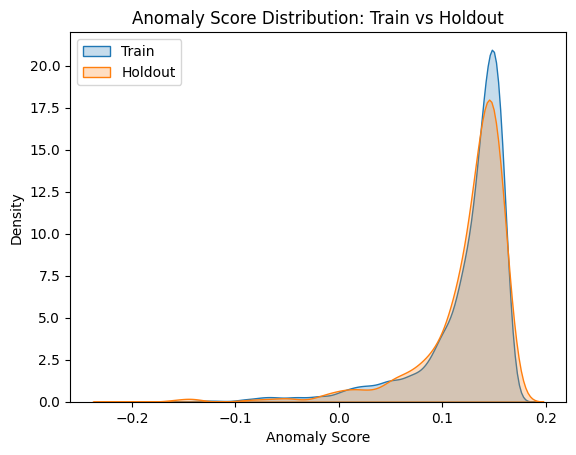

In [41]:
sns.kdeplot(anomaly_scores_decision_train, label="Train", fill=True)
sns.kdeplot(anomaly_scores_decision_hold, label="Holdout", fill=True)
plt.title("Anomaly Score Distribution: Train vs Holdout")
plt.xlabel("Anomaly Score")
plt.legend()
plt.show()


Train and Holdout anomaly score distributions overlap almost perfectly, indicating stability.

In [42]:
threshold = 0  # decision_function threshold for anomalies
train_rate = (anomaly_scores_decision_train < threshold).mean()
holdout_rate = (anomaly_scores_decision_hold < threshold).mean()

print(f"Train anomaly rate: {train_rate:.2%}")
print(f"Holdout anomaly rate: {holdout_rate:.2%}")


Train anomaly rate: 2.96%
Holdout anomaly rate: 2.94%


In [43]:
from scipy.stats import ks_2samp

ks_stat, p_val = ks_2samp(
    anomaly_scores_decision_train,
    anomaly_scores_decision_hold
)
print(f"KS statistic: {ks_stat:.4f}, p-value: {p_val:.4f}")

if p_val < 0.05:
    print("The distributions are significantly different")
else:
    print("The distributions are not significantly different")

KS statistic: 0.0321, p-value: 0.1084
The distributions are not significantly different


A KS value close to 0 (above: 0.0321) indicates the distributions are very similar, which aligns with the non-significant p-value.

In [44]:
def calculate_psi(expected, actual, bins=10):
    breakpoints = np.linspace(0, 1, bins + 1)
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)

    psi = np.sum(
        (actual_percents - expected_percents) * np.log((actual_percents + 1e-6) /
        (expected_percents + 1e-6))
    )
    return psi

In [45]:
psi_score = calculate_psi(anomaly_scores_decision_train, anomaly_scores_decision_hold)

print(f"Population Stability Index (PSI) score: {psi_score:.5f}")
if psi_score < 0.1:
    print("- No significant population change")
elif psi_score < 0.2:
    print("- Moderate population change")
else:
    print("- Significant population change")

Population Stability Index (PSI) score: 0.00006
- No significant population change


The model’s behavior on holdout data is consistent with training. No indication of drift or overfitting.

**Important note**: Even if the KS test had shown significance or PSI suggested drift, it wouldn’t necessarily indicate a problem. For example, bot traffic could cluster early in the day, creating natural distribution differences. However, the current results suggest the assumption of stability holds true.

Similarly to before, here’s a look at the anomalous observations.

In [46]:
param_df = df_holdout_raw['params_dict'].apply(pd.Series)
df_manual_holdout = pd.concat([
    df_holdout_raw.drop(columns=['url_params','params_dict']),
    param_df],
    axis=1
)
df_manual_holdout['q'] = df_manual['q'].apply(unquote)

In [47]:
df_manual_holdout = pd.concat([
    df_manual_holdout,
    res_df_hold[['is_anomaly','anomaly_score']]
], axis=1)

In [48]:
# originally looked through all of them, but for this notebook
# printing out only few ones
df_manual_holdout[df_manual_holdout['is_anomaly']].tail(10)

,datetime,region,browser,device,hour,n,f,d,sld,st,nt,r,adx,adx_name,ttc,q,ct,kl,kp,bkl,om,lsexp1,atb,va,atbexp,atbva,is_anomaly,anomaly_score
1172,2019-12-02 22:47:56,Mercury,Brave,iOS,22,1,1,jp.iherb.com,1,mobile_search_intl,0,0,none,none,1593,ck deceits,JP,wt-wt,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.048883
1185,2019-12-02 22:51:11,Mercury,Edge,Android,22,1,1,www.pressbrakeurethane.com,0,mobile_search_intl,0,0,none,none,4915,felid sket,ID,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.052732
1223,2019-12-02 22:57:19,Mercury,Chrome,Android,22,1,1,www.zoro.com,1,mobile_search_intl,0,0,none,none,4283,remeet uhs shavester gusher,ID,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.023303
1241,2019-12-02 22:59:10,Mars,UCBrowser,Android,22,1,1,www.dx.com,1,mobile_search_intl,0,0,none,none,4033,cite sarod,SE,es-es,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.206414
1352,2019-12-02 23:21:10,Saturn,Brave,iOS,23,1,1,www.expedia.com,1,mobile_search_intl,0,0,none,none,7126,hoondee,QA,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.026552
1465,2019-12-02 23:42:14,Jupiter,Safari,Android,23,1,1,watch.nba.com,0,mobile_search_intl,0,0,none,none,5993,teetered cavil,AU,uk-en,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.005014
1474,2019-12-02 23:44:03,Venus,Chrome,Android,23,1,1,www.adobe.com,1,mobile_search_intl,0,0,none,none,715,pechs lums culex,MX,mx-es,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.000473
1476,2019-12-02 23:44:15,Mars,Edge,Android,23,1,1,www.192.com,0,mobile_search_intl,0,0,none,none,2582,dowitch aver,GB,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.137077
1548,2019-12-02 23:58:02,Venus,Chrome,Android,23,1,1,www.adobe.com,1,mobile_search_intl,0,0,none,none,906,splenocyte kae,MX,mx-es,-1,NaN,NaN,a,NaN,NaN,NaN,NaN,True,-0.002374
1559,2019-12-02 23:59:40,Mars,UCBrowser,Android,23,1,1,www.naf.no,1,mobile_search_intl,0,0,none,none,10816,boatel xylenes,NO,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.160114


Upon reviewing these samples, the behavior appears consistent with automated activity, primarily based on the query content and the associated ad domains. The queries are often composed of random or unnatural word sequences, sometimes oddly specific, while the clicked ads frequently lack logical relevance. For example, in the last sample, `xylenes` refers to a chemical, whereas `naf.no` is a Norwegian car service/roadside assistance company. Even if a chemical connection could be argued in that case, an ad for an NBA game in response to a query like `teetered cavil` is highly unlikely to reflect genuine user intent.

It can therefore be concluded that the model successfully identifies at least some anomalous behavior.